In [1]:
folder_path = 'Data/multilexnorm/data/'
file_path = 'en/train.norm'
data_path = folder_path + file_path

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv(data_path, sep='\t', quotechar="'")
df.rename(columns={'rt': 'raw', 'rt.1': 'norm'}, inplace=True)
df.head(11)

,raw,norm
0,@teddyferrari1,@teddyferrari1
1,:,:
2,"""",""""
3,ah,ah
4,...,...
5,@datzmenoni,@datzmenoni
6,:,:
7,why,why
8,sub,sub
9,ozil,ozil


In [4]:
raw = []
norm = []

with open(data_path, 'r') as f:
    tweet_raw = []
    tweet_norm = []
    for line in f:
        if line == '\n':
            raw.append(" ".join(tweet_raw))
            norm.append(" ".join(tweet_norm))
            tweet_raw = []
            tweet_norm = []
        else:
            tokens = line.split()

            tweet_raw.append(tokens[0])
            tweet_norm.extend(tokens[1:])

In [5]:
raw[:5]

['rt @teddyferrari1 : " ah ... @datzmenoni : why sub ozil " @lexzydoo_ab : opolo eyes u no fit open eyes ""',
 'u have a very sexy header @jaibrooks1 rawr',
 'i miss u my bie ! where u wanna out wif me ? have a wonderful day like a swan day .. haha ..',
 '" cantik . rt @historyinpics : julie christie , 1968 . photograph by richard avedon . http://t.co/gscav8o0ik "',
 'rt @fvckxhemmings : did calum slip ?!! omfg']

In [6]:
norm[:5]

['rt @teddyferrari1 : " ah ... @datzmenoni : why sub ozil " @lexzydoo_ab : opolo eyes you no fit open eyes ""',
 'you have a very sexy header @jaibrooks1 rawr',
 'i miss you my bie ! where you want to out with me ? have a wonderful day like a swan day .. haha ..',
 '" cantik . rt @historyinpics : julie christie , 1968 . photograph by richard avedon . http://t.co/gscav8o0ik "',
 'rt @fvckxhemmings : did calum slip ?!! omfg']

## Cleaning the data

In [7]:
!pip install tweet-preprocessor

In [8]:
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.NUMBER)

In [9]:
def clean_text(s):
    return p.clean(s)

In [10]:
c_raw = [clean_text(s) for s in raw]
c_norm = [clean_text(s) for s in norm]

In [11]:
c_raw[:5]

['rt : " ah ... : why sub ozil " : opolo eyes u no fit open eyes ""',
 'u have a very sexy header rawr',
 'i miss u my bie ! where u wanna out wif me ? have a wonderful day like a swan day .. haha ..',
 '" cantik . rt : julie christie , . photograph by richard avedon . "',
 'rt : did calum slip ?!! omfg']

In [12]:
c_norm[:5]

['rt : " ah ... : why sub ozil " : opolo eyes you no fit open eyes ""',
 'you have a very sexy header rawr',
 'i miss you my bie ! where you want to out with me ? have a wonderful day like a swan day .. haha ..',
 '" cantik . rt : julie christie , . photograph by richard avedon . "',
 'rt : did calum slip ?!! omfg']

## Observations

In [13]:
'''Conversion map for words that can be normalized, {raw_word: {'opt_1': freq_1, 'opt_2':freq_2}}'''
conversion_map = {}
freq_map = {}
one_to_n = {}

for index, row in df.iterrows():
    raw = str(row['raw'])
    norm = str(row['norm'])
    
    if  raw != norm and raw != '\t':
        # conversion to normalized
        if raw not in conversion_map.keys():
            conversion_map[raw] = {}
        if norm not in conversion_map[raw].keys():
            conversion_map[raw][norm] = 1
        else:
            conversion_map[raw][norm] += 1

        # frequency of conversions
        if raw not in freq_map.keys():
            freq_map[raw] = 1
        else:
            freq_map[raw] += 1
        
        # 1-n conversions
        if len(raw.split()) < len(norm.split()):
            if raw not in one_to_n.keys():
                one_to_n[raw] = []
            one_to_n[raw].append(norm)

### Frequently Occuring Normalizations


In [14]:
freq_map_sorted = sorted(freq_map.items(), key=lambda item: -item[1])
freq_map_sorted[:10]

[('u', 271),
 ('im', 148),
 ('dont', 72),
 ('nigga', 49),
 ('niggas', 45),
 ('n', 41),
 ('pls', 35),
 ('ur', 35),
 ('lil', 32),
 ('thats', 30)]

### The Conversions

In [15]:
for i in range(10):
    print(f"{i + 1}: {freq_map_sorted[i]} -> {str(conversion_map[freq_map_sorted[i][0]])}")

1: ('u', 271) -> {'you': 266, "you're": 2, 'your': 3}
2: ('im', 148) -> {"i'm": 147, 'i': 1}
3: ('dont', 72) -> {"don't": 72}
4: ('nigga', 49) -> {'nigger': 49}
5: ('niggas', 45) -> {'niggers': 45}
6: ('n', 41) -> {'and': 39, 'at': 1, 'in': 1}
7: ('pls', 35) -> {'please': 35}
8: ('ur', 35) -> {'your': 25, "you're": 9, 'you': 1}
9: ('lil', 32) -> {'little': 32}
10: ('thats', 30) -> {"that's": 30}


### 1-N conversions

In [16]:
print(f"No. of 1-N conversions: {len(one_to_n)}")

No. of 1-N conversions: 144


Sorting according to types of *1-N conversions per word*

In [17]:
one_to_n_sorted = sorted(one_to_n.items(), key=lambda item: -len(item[1]))
one_to_n_sorted[4]

('finna',
 ['going to',
  'going to',
  'going to',
  'going to',
  'going to',
  'going to',
  'going to',
  'going to',
  'going to',
  'going to'])

Here, **finna** is commonly normalized to **going to**, although the web tells that its *normalized version* is **fixing to**

In [18]:
print("Top 10 1-N Conversions:\n")
for i in range(10):
    w, r = one_to_n_sorted[i]
    print(f"{i}: {w} -> {r[0]}")

Top 10 1-N Conversions:

0: gonna -> going to
1: ima -> i'm going to
2: imma -> i'm going to
3: tryna -> trying to
4: finna -> going to
5: dm -> direct message
6: wanna -> want to
7: tf -> the fuck
8: af -> as fuck
9: rn -> right now


### Edit Distances

In [19]:
def edit_distance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [20]:
edit_distances = []

for raw in conversion_map.keys():
    for norm in conversion_map[raw].keys():
        dist = edit_distance(raw, norm)
        freq = conversion_map[raw][norm]
        '''to include duplicates'''
        # dist_freq = [dist for i in range(freq)]
        '''to only have uniques'''
        dist_freq = [dist]
        edit_distances.extend(dist_freq)

In [21]:
print(f"Maximum edit distance recorded: {int(max(edit_distances))}")

Maximum edit distance recorded: 29


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

Plots that also consider the frequency of words, i.e *includes duplicates too*. **(Might not be as useful)**

Text(0.5, 1.0, 'Frequency vs Edit Distance')

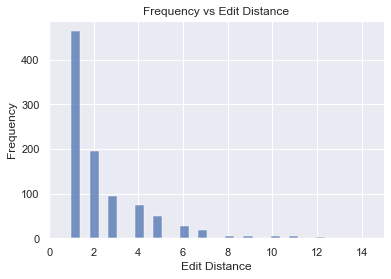

In [23]:
fig, ax = plt.subplots()
sns.histplot(edit_distances, ax=ax)
ax.set_xlim(0, 15)
ax.set(xlabel="Edit Distance", ylabel="Frequency")
ax.set_title("Frequency vs Edit Distance")

Text(0.5, 1.0, 'Frequency vs Edit Distance')

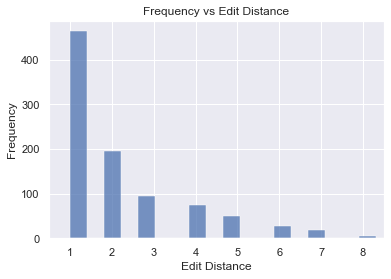

In [24]:
fig, ax = plt.subplots()
sns.histplot(edit_distances, ax=ax)
ax.set_xlim(0.5, 8.5)
ax.set(xlabel="Edit Distance", ylabel="Frequency")
ax.set_title("Frequency vs Edit Distance")

Next plots consider only **unique non-canonical words**

Text(0.5, 1.0, 'Frequency vs Edit Distance')

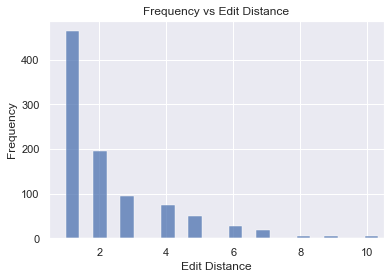

In [25]:
fig, ax = plt.subplots()
sns.histplot(edit_distances, ax=ax)
ax.set_xlim(0.5, 10.5)
ax.set(xlabel="Edit Distance", ylabel="Frequency")
ax.set_title("Frequency vs Edit Distance")

Text(0.5, 1.0, 'Frequency vs Edit Distance')

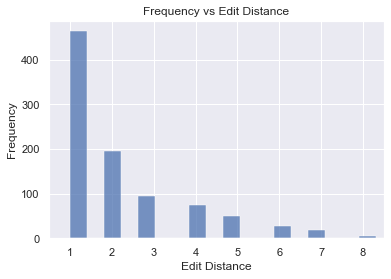

In [26]:
fig, ax = plt.subplots()
sns.histplot(edit_distances, ax=ax)
ax.set_xlim(0.5, 8.5)
ax.set(xlabel="Edit Distance", ylabel="Frequency")
ax.set_title("Frequency vs Edit Distance")

Major edit distances occur in the maximum range till 7, with the *heighest being for 1*.
### Normalized Edit Distances

In [27]:
norm_edit_distances = []

for raw in conversion_map.keys():
    for norm in conversion_map[raw].keys():
        dist = edit_distance(raw, norm)
        freq = conversion_map[raw][norm]
        norm_len = len(raw)
        '''includes duplicates'''
        # dist_freq = [dist/norm_len for i in range(freq)]
        '''includes only unique occurrences'''
        dist_freq = [dist/norm_len]
        norm_edit_distances.extend(dist_freq)

In [28]:
print(f"Maximum normalized edit distance recorded: {int(max(norm_edit_distances))}")

Maximum normalized edit distance recorded: 7


These plots include duplicates, i.e *they are considering all the occurences of a word*. **(might not be as useful)**

Text(0.5, 1.0, 'Frequency vs Normalized Edit Distance')

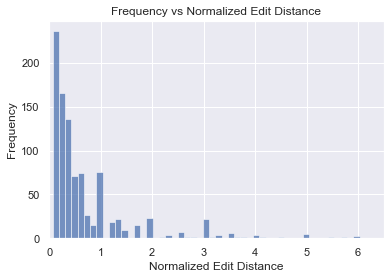

In [29]:
fig, ax = plt.subplots()
sns.histplot(norm_edit_distances, ax=ax)
ax.set_xlim(0, 6.5)
ax.set(xlabel="Normalized Edit Distance", ylabel="Frequency")
ax.set_title("Frequency vs Normalized Edit Distance")

Next plots only *include unique occurences* of the raw words

Text(0.5, 1.0, 'Frequency vs Normalized Edit Distance - (1, 5)')

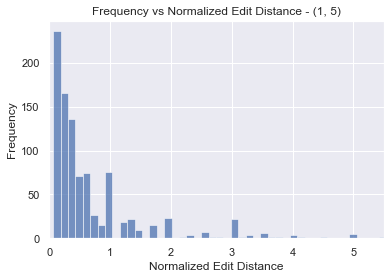

In [30]:
fig, ax = plt.subplots()
sns.histplot(norm_edit_distances, ax=ax)
ax.set_xlim(0, 5.5)
ax.set(xlabel="Normalized Edit Distance", ylabel="Frequency")
ax.set_title("Frequency vs Normalized Edit Distance - (1, 5)")

Text(0.5, 1.0, 'Frequency vs Normalized Edit Distance - (0, 1)')

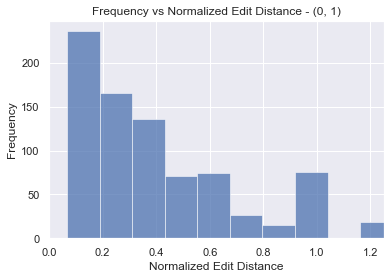

In [31]:
fig, ax = plt.subplots()
sns.histplot(norm_edit_distances, ax=ax)
ax.set_xlim(0, 1.25)
ax.set(xlabel="Normalized Edit Distance", ylabel="Frequency")
ax.set_title("Frequency vs Normalized Edit Distance - (0, 1)")

For **Normalized** edit distances, major edit distances occur in the maximum range upto 5, with *most squeezed between* (0, 1].

# Running and Testing Data on Monoise